Text(0, 0.5, 'Y position')

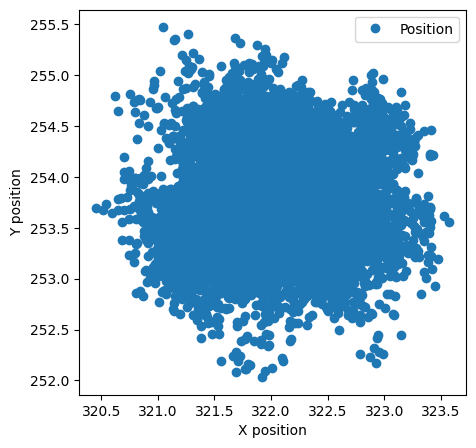

In [585]:
import numpy as np
from matplotlib import pyplot as plt
filename = '20230510_115318'
filepath = f"data/analyze_particle/{filename}.txt"
result_img = f"result/img/{filename}.png"
result_txt= f"result/txt/{filename}.txt"

with open(filepath, 'r') as file:
    time_val, x_val, y_val = [], [], []
    header = file.readline().strip().split('\t')
    for line in file:
        values = line.strip().split('\t')
        time_val.append(float(values[0]))
        x_val.append(float(values[3]))
        y_val.append(float(values[4]))
        
time_val, x_val, y_val = np.array(time_val), np.array(x_val), np.array(y_val)
plt.figure(figsize=(5,5))
plt.plot(x_val, y_val, 'o', label='Position')
plt.legend()
plt.xlabel("X position")
plt.ylabel("Y position")

Equation of fitted linear function: y= 0.05596100009681082 x + 235.74143357144638
Line equation has been copied to clipboard


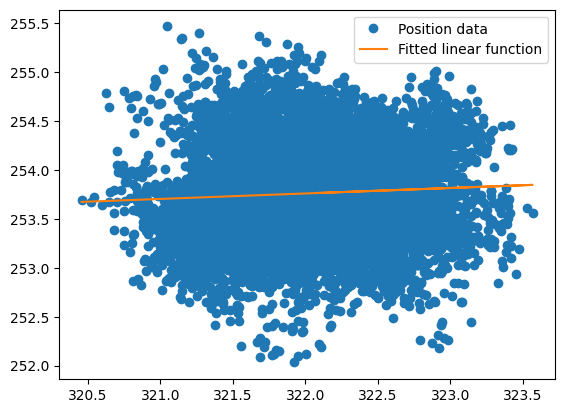

In [586]:
import pyperclip
from scipy.optimize import curve_fit

rectangle = 'makeRectangle(243, 170, 150, 160);'
rectangle = rectangle.replace("makeRectangle","")
rectangle = rectangle.replace(";","")

#Obtaining the coordinates of the rectangle
rct = rectangle.strip("()").split(", ")
rct = [int(x) for x in rct]

startLine = int(rct[0])

# Define the linear function
def linear(x, m, c):
    return m * x + c

# Load the position diagram data
x_data = x_val # Your x position data here
y_data = y_val # Your y position data here

# Fit the linear function to the data
popt, pcov = curve_fit(linear, x_data, y_data)

# Extract the fitted parameters
m_fit, c_fit = popt

# Fitted parameters to create function in ImageJ
x1 = float(rct[0])
y1 = x1 * m_fit + c_fit
x2 = x1 + rct[2]
y2 = x2 * m_fit + c_fit

print("Equation of fitted linear function: y=",m_fit,"x +", c_fit)
line_equation = (f'makeLine({x1},{y1},{x2},{y2});')

pyperclip.copy(line_equation)
print("Line equation has been copied to clipboard")
# Plot the position diagram and the fitted linear function
fig, ax = plt.subplots()
ax.plot(x_data, y_data, 'o', label='Position data')
ax.plot(x_data, linear(x_data, m_fit, c_fit), label='Fitted linear function')
ax.legend()
plt.show()

Plot profile successfully executed


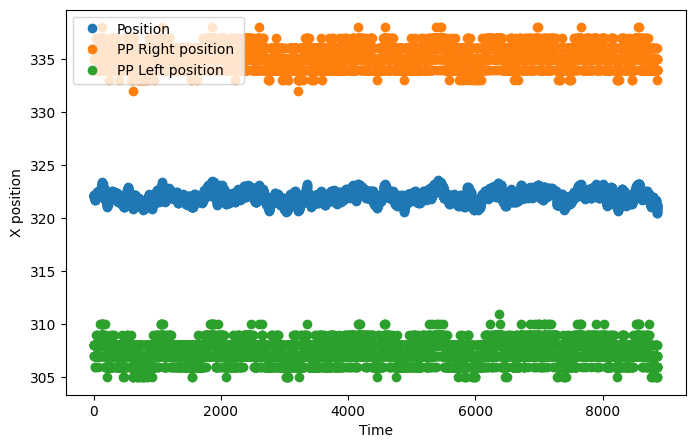

In [587]:
import util
plot_profile = util.get_local_minima(filename)

if plot_profile:
    print ("Plot profile successfully executed")
    
pp_left, pp_right = [], []

for sublist in plot_profile:
    pp_left.append(startLine + sublist[0][0])
    pp_right.append(startLine + sublist[1][0])

pp_left = np.array(pp_left)
pp_right = np.array(pp_right)

plt.figure(figsize=(8,5))
plt.plot(time_val, x_val, 'o', label='Position')
plt.plot(time_val, pp_right, 'o', label='PP Right position ')
plt.plot(time_val, pp_left, 'o', label='PP Left position')
plt.legend()
plt.xlabel("Time")
plt.ylabel("X position")
plt.show()

Here, PP is the plot profile. The PP is not in X axis, instead its the distance on the fitted line. So then we can calculate the radius by using the half ot the distance between left and right PP points.

In [588]:
radius = np.around((np.average(pp_right)-np.average(pp_left))*0.048/2, 3)
print ("The radius of the droplet is", radius, "um")

The radius of the droplet is 0.668 um


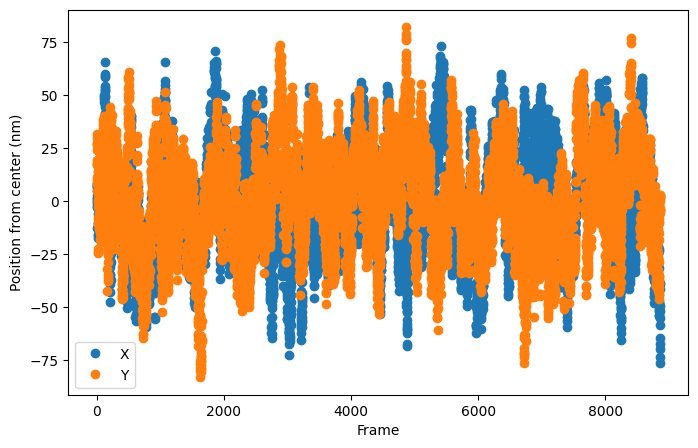

In [589]:
norm_x, norm_y = x_val - np.average(x_val), y_val - np.average(y_val)
norm_x *= 48
norm_y *= 48

def save_list_to_file(my_list, filename):
    with open(filename, 'w') as f:
        for item in my_list:
            f.write("%s\n" % item)

autonumber = list(range(1, len(norm_x) + 1))

#save_list_to_file(autonumber, "frames.txt")
#save_list_to_file(norm_x, "x.txt")
#save_list_to_file(norm_y, "y.txt")

plt.figure(figsize=(8,5))
plt.plot(time_val, norm_x, 'o', label='X')
plt.plot(time_val, norm_y, 'o', label='Y')
plt.legend()
plt.xlabel("Frame")
plt.ylabel("Position from center (nm)")
plt.show()

Length of PSD: 513
Largest PSD value: 155.53379294037484


/var/folders/j6/qtxxrjsj3yv9b1741mj7ybn40000gn/T/ipykernel_23951/3276738586.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(np.min(freqs))


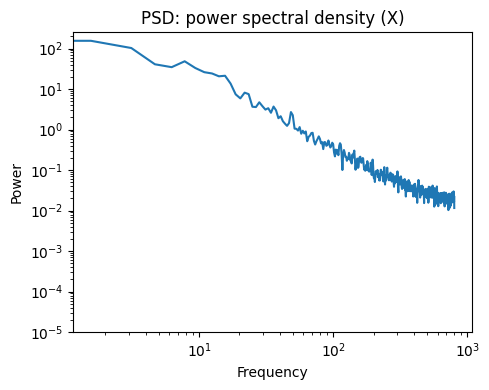

In [590]:
from scipy import signal
video_FPS = 800
freqs, psd = signal.welch(window='hann',x= norm_x, nperseg = 1024, scaling= 'density')

freqs *= 2 * video_FPS
psd /= video_FPS

print("Length of PSD:", len(freqs))
print("Largest PSD value:", np.max(psd))

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.yscale("log")
plt.xscale("log")
plt.ylim(10e-6)
plt.xlim(np.min(freqs))
plt.title('PSD: power spectral density (X)')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

Lorentzian fit coefficients:
psi_0 = 89.27837303866951
fc_0 = 7.179025257502441
k = 0.00402 (T= 293.15 K)


/var/folders/j6/qtxxrjsj3yv9b1741mj7ybn40000gn/T/ipykernel_23951/1627279886.py:32: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[0].set_xlim(np.min(freqs))


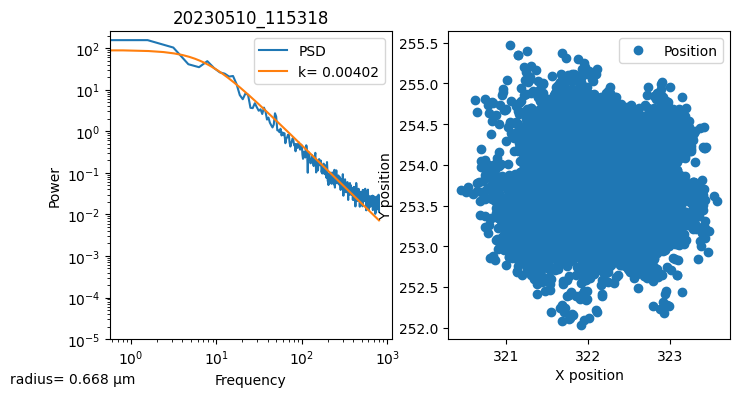

In [591]:
from scipy.optimize import curve_fit

def lorentzian(x, psi0, fc):
    return psi0/(1+(x/fc)**2)

# Fit the Lorentzian function to the PSD data
popt, pcov = curve_fit(lorentzian, freqs, psd, p0=[1, 1])

# Get the coefficients of the Lorentzian fit
psi0_fit, fc_fit = popt[0], abs(popt[1])

# Generate the Lorentzian fit curve
freq_fit = np.linspace(np.min(freqs), np.max(freqs), 1000)
psd_fit = lorentzian(freq_fit, *popt)

print("Lorentzian fit coefficients:")
print("psi_0 =", psi0_fit)
print("fc_0 =", fc_fit)
k_constant = 2*(1.38E-23)*293.15/(3.14*psi0_fit*fc_fit)*1E+21
k_constant = np.round(k_constant, decimals=5)
print("k =", k_constant, ("(T= 293.15 K)"))

# set the figure size and dpi
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=100)

# plot the first subplot
axs[0].plot(freqs, psd, label='PSD')
axs[0].plot(freq_fit, psd_fit, label="k= " + str(k_constant))
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_ylim(10e-6)
axs[0].set_xlim(np.min(freqs))
axs[0].set_title(filename)
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Power')
axs[0].legend()


# plot the second subplot
axs[1].plot(x_val, y_val, 'o', label='Position')
axs[1].legend()
axs[1].set_xlabel("X position")
axs[1].set_ylabel("Y position")
plt.figtext(x=0,y=0,s='radius= '+str(radius)+' μm')
# save the figure
plt.savefig(result_img, format='png', bbox_inches='tight', dpi=300)

# Saves the result in the format
# radius
# k_constant
result = np.array([radius, k_constant])
np.savetxt(result_txt, result, delimiter=',')